In [1]:
import uproot
import coffea
from coffea import hist
import numpy as np
import seutils
from math import pi

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
base = 'root://cmseos.fnal.gov//store/user/klijnsma/semivis/flatntuple_Apr30/'
datasets = [base +d for d in [
    'merged_Mar25s-channel_mMed-150_mDark-20_rinv-0_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root',
    'merged_Mar25s-channel_mMed-250_mDark-20_rinv-0.3_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root',
    'merged_Mar25s-channel_mMed-250_mDark-20_rinv-0_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root',
    'merged_Mar25s-channel_mMed-450_mDark-20_rinv-0.3_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root',
    'merged_Mar25s-channel_mMed-450_mDark-20_rinv-0_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root',
    'merged_Mar25s-channel_mMed-50_mDark-20_rinv-0.3_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root',
    'merged_Mar25s-channel_mMed-50_mDark-20_rinv-0_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root',
    'merged_Mar25s-channel_mMed-650_mDark-20_rinv-0.3_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root',
    'merged_Mar25s-channel_mMed-650_mDark-20_rinv-0_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root',
    ]]
rootfile = datasets[1]
print(rootfile)

root://cmseos.fnal.gov//store/user/klijnsma/semivis/flatntuple_Apr30/merged_Mar25s-channel_mMed-250_mDark-20_rinv-0.3_alpha-peak_HT400_13TeV-madgraphMLM-pythia8.root


In [3]:
fin = uproot.open(rootfile)
tree = fin[b'SoftdropAnalyzer'][b'tree']
def get_branch(branchname):
    return tree.arrays(branchname)[branchname]

In [5]:
def deltar(eta1, phi1, eta2, phi2):
    deta = eta1 - eta2
    dphi = phi1 - phi2
    dphi[dphi > 2.*pi] -= 2.*pi
    dphi[dphi < -2.*pi] += 2.*pi
    dphi[dphi > pi] -= 2.*pi
    dphi[dphi < -pi] += 2.*pi
    return deta, dphi, np.sqrt(deta**2 + dphi**2)

In [65]:
all_zprime = get_branch(b'zprime_p4')
all_dark_quarks = get_branch(b'final_dark_quarks_p4')
all_dark_mesons = get_branch(b'dark_mesons_decaying_dark_p4')
all_dark_mesons_decaying_visible = get_branch(b'dark_mesons_decaying_visible_p4')
all_visible_particles = get_branch(b'final_visible_particles_p4')
all_met = get_branch(b'met')

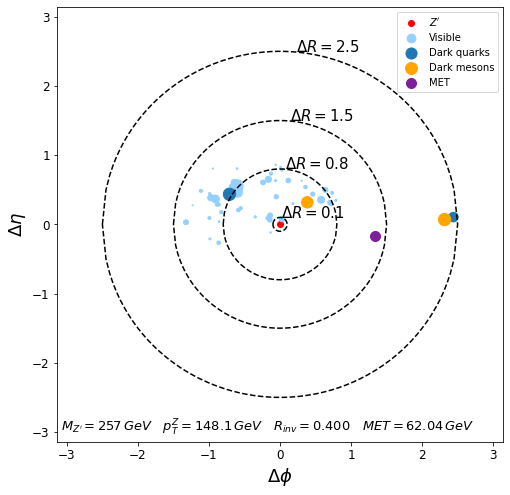

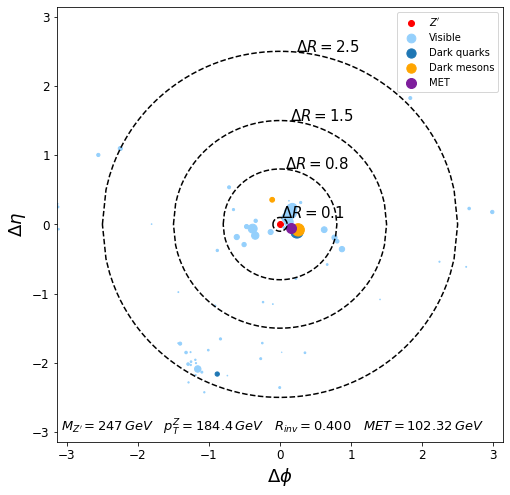

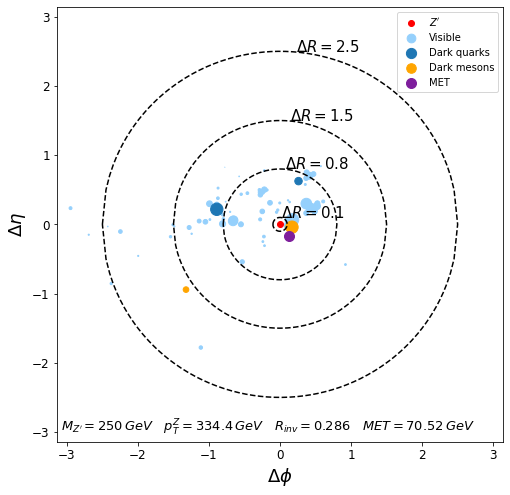

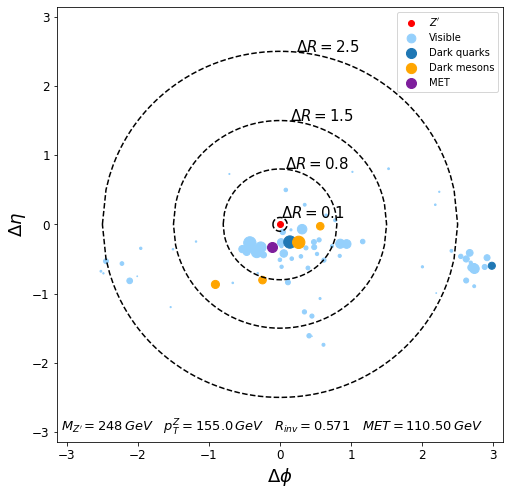

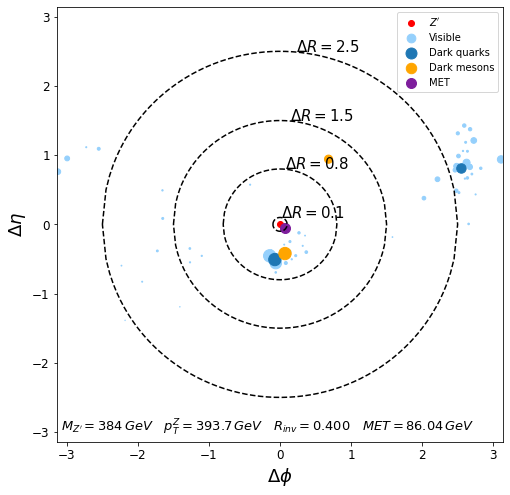

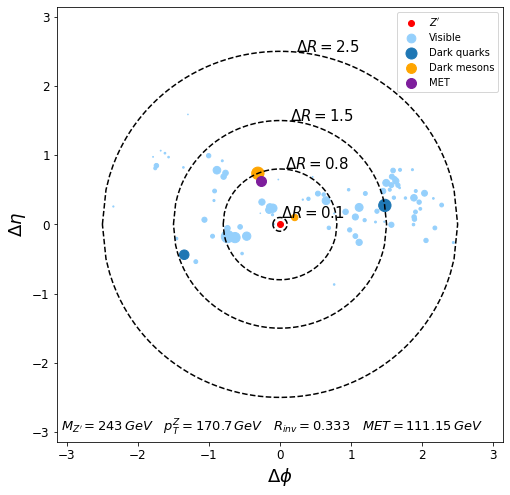

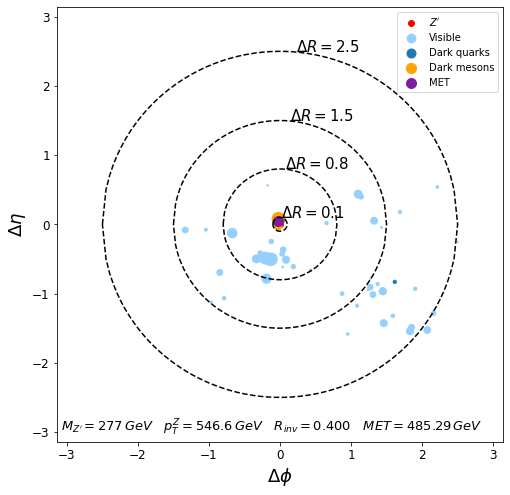

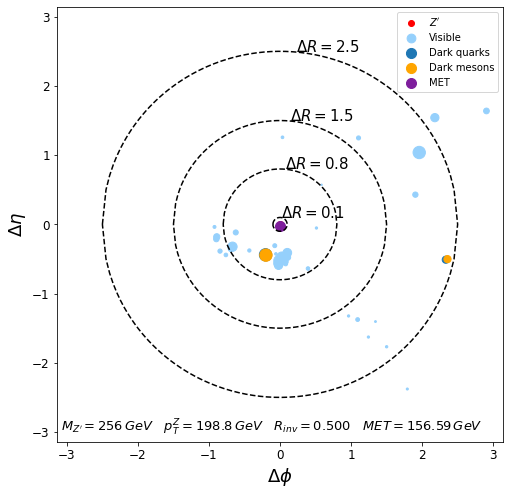

In [90]:
def get_dr_ring(dr, n_points=100):        
    deta = np.linspace(-dr, dr, n_points)
    dphi = np.sqrt(dr**2 - np.square(deta))
    deta = np.concatenate((deta, deta[::-1]))
    dphi = np.concatenate((dphi, -dphi[::-1]))
    return deta, dphi

def plot(ievt, ax=None):
    zprime = all_zprime[ievt]
    dark_quarks = all_dark_quarks[ievt]
    dark_mesons = all_dark_mesons[ievt]
    dark_mesons_decaying_visible = all_dark_mesons_decaying_visible[ievt]
    visible_particles = all_visible_particles[ievt]
    met = all_met[ievt]
    
    if ax is None:
        fig = plt.figure(figsize=(8,8))
        ax = plt.gca()
    ax.scatter([0.], [0.], c='r', label=r'$Z^{\prime}$')
    ax.set_xlim(-pi, pi)
    ax.set_ylim(-pi, pi)
    ax.set_xlabel(r'$\Delta\phi$', fontsize=18)
    ax.set_ylabel(r'$\Delta\eta$', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=12)
        
    for dr in [ 0.1, 0.8, 1.5, 2.5 ]:
        etas, phis = get_dr_ring(dr)
        label_index = int(len(etas)*0.27)
        ax.plot(etas, phis, color='k', linestyle='--')
        ax.text(
            etas[label_index], phis[label_index],
            r'$\Delta R={0:.1f}$'.format(dr),
            fontsize=15
            )
        
    def deltar_withzprime(particles):
        return deltar(
            particles.eta, particles.phi,
            zprime.eta, zprime.phi
            )

    def scale(particles):
        """Just to scale to a reasonable dot size"""
        energies = particles.energy
        if len(energies) == 0: return []
        e_max = np.max(energies)
        e_normed = 200.*np.tanh(energies/e_max)
        return e_normed
    
    deta_visible_particles, dphi_visible_particles, dr_visible_particles = deltar_withzprime(visible_particles)
    ax.scatter(dphi_visible_particles, deta_visible_particles, s=scale(visible_particles), label='Visible', c='xkcd:light blue')

    deta_dark_quarks, dphi_dark_quarks, dr_dark_quarks = deltar_withzprime(dark_quarks)
    ax.scatter(dphi_dark_quarks, deta_dark_quarks, s=scale(dark_quarks), label='Dark quarks')

    deta_dark_mesons, dphi_dark_mesons, dr_dark_mesons = deltar_withzprime(dark_mesons)
    ax.scatter(dphi_dark_mesons, deta_dark_mesons, s=scale(dark_mesons), label='Dark mesons', c='orange')
        
    deta_met, dphi_met, dr_met = deltar_withzprime(met)
    ax.scatter(dphi_met, deta_met, s=100., label='MET', c='xkcd:purple')    
    
    ax.legend()
    rinv_denom = len(dark_mesons_decaying_visible)+len(dark_mesons)
    rinv = len(dark_mesons) / rinv_denom if rinv_denom > 0. else 0.
    ax.text(
        0.01, 0.01,
        (
            r'$M_{{Z^{{\prime}}}} = {0:0d}\,GeV'
            r' \quad p_{{T}}^{{Z}} = {1:.1f}\,GeV'
            r' \quad R_{{inv}} = {2:.3f}'
            r' \quad MET = {3:.2f}\,GeV$'
            .format(int(zprime.mass[0]), zprime.pt[0], rinv, met.pt)
            ),
        verticalalignment='bottom', horizontalalignment='left',
        transform = ax.transAxes,
        fontsize=13
        )

    
# figure, axs = plt.subplots(nrows=3, ncols=2, figsize=(16,24))
# axs_flat = axs.flatten()
# for i in range(6):
#     plot(i+5, ax=axs_flat[i])

n = 0
for i in range(100):
    if all_zprime.counts[i] == 0: continue
    if all_met[i].pt > 50.:
        plot(i)
        n += 1
    if n == 8: break